로지스틱 회귀분석 연습

In [391]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [392]:
df = pd.read_csv("titanic.csv")
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


C:\Users\gg787\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='age', ylabel='survived'>

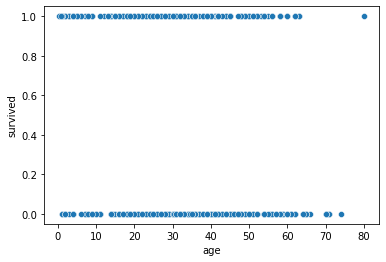

In [393]:
import seaborn as sns

sns.scatterplot("age","survived", data = df)

In [394]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


In [395]:
df.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [396]:
df["age"] = df["age"].fillna(df["age"].mean())
df = df.drop("deck", axis = 1)
df = df.drop("embarked", axis = 1)
df = df.drop("who", axis = 1)
df = df.drop("adult_male",axis = 1)
df = df.drop("alive",axis = 1)
df = df.drop("alone",axis = 1)
df = df.drop("pclass", axis = 1)
df["embark_town"] = df["embark_town"].fillna("Southampton") 

In [397]:
object_col = df.dtypes[df.dtypes == "object"].index.tolist()

In [398]:
# for i in object_col:
#     df[i] = pd.factorize(df[i])[0]

In [399]:
df = pd.get_dummies(data = df, columns = object_col,drop_first = False)

In [400]:
df = df.astype(float)
# stats_model api 만있는문제 : 모든 데이터를 float 형태로 맞춰줘야함

In [401]:
feature = df.drop("survived", axis = 1)
label = df["survived"]

In [402]:
from sklearn.model_selection import train_test_split

In [403]:
X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size = 0.3, random_state = 2020) #random_state 를 설정해주자!

In [404]:
import statsmodels.api as sm
model = sm.Logit(y_train, X_train)
result = model.fit() #중복되는 컬럼을 최대한 없애자

Optimization terminated successfully.
         Current function value: 0.419050
         Iterations 7


In [405]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:               survived   No. Observations:                  623
Model:                          Logit   Df Residuals:                      613
Method:                           MLE   Df Model:                            9
Date:                Fri, 22 Apr 2022   Pseudo R-squ.:                  0.3661
Time:                        16:53:31   Log-Likelihood:                -261.07
converged:                       True   LL-Null:                       -411.83
Covariance Type:            nonrobust   LLR p-value:                 1.236e-59
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
age                        -0.0325      0.009     -3.527      0.000      -0.051      -0.014
sibsp                      -0.2349      0.125     -1.873      0.061      -0.481       0.011


In [406]:
# 성능척도
print("Model AIC :", result.aic)

Model AIC : 542.1364467669067


In [407]:
import time
import itertools
def processSubset(X,y, feature_set):
            model = sm.Logit(y,X[list(feature_set)]) # Modeling
            regr = model.fit() # 모델 학습
            AIC = regr.aic # 모델의 AIC
            return {"model":regr, "AIC":AIC}
        
'''
전진선택법
'''
def forward(X, y, predictors):
    
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    remaining_predictors = [p for p in X.columns if p not in predictors]
    results = []
    for p in remaining_predictors:
        results.append(processSubset(X=X, y= y, feature_set=predictors+[p]))
        
    # 데이터프레임으로 변환
    models = pd.DataFrame(results)

    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()] # index

    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in")
    print('Selected predictors:',best_model['model'].model.exog_names,' AIC:',best_model[0] )
    return best_model

'''
후진소거법
'''
def backward(X,y,predictors):
    tic = time.time()
    results = []
    
    # 데이터 변수들이 미리정의된 predictors 조합 확인
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X=X, y= y,feature_set=list(combo)))
    models = pd.DataFrame(results)
    
    # 가장 낮은 AIC를 가진 모델을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors) - 1, "predictors in",
          (toc - tic))
    print('Selected predictors:',best_model['model'].model.exog_names,' AIC:',best_model[0] )
    return best_model



'''
단계적 선택법
'''

def Stepwise_model(X,y):
    Stepmodels = pd.DataFrame(columns=["AIC", "model"])
    tic = time.time()
    predictors = [X.columns[0]]
    Smodel_before = processSubset(X,y,predictors)['AIC']
    # 변수 1~10개 : 0~9 -> 1~10
    for i in range(1, len(X.columns) + 1):
        Forward_result = forward(X=X, y=y, predictors=predictors) # constant added
        print('forward')
        Stepmodels.loc[i] = Forward_result
        predictors = Stepmodels.loc[i]["model"].model.exog_names
        predictors = [ k for k in predictors]
        Backward_result = backward(X=X, y=y, predictors=predictors)
        if Backward_result['AIC']< Forward_result['AIC']:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]["model"].model.exog_names
            Smodel_before = Stepmodels.loc[i]["AIC"]
            predictors = [ k for k in predictors]
            print('backward')
        if Stepmodels.loc[i]['AIC']> Smodel_before:
            break
        else:
            Smodel_before = Stepmodels.loc[i]["AIC"]
    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")
    return (Stepmodels['model'][len(Stepmodels['model'])])

In [408]:
Stepwise_best_model = Stepwise_model(X_train, y_train)

Optimization terminated successfully.
         Current function value: 0.663422
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.662263
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.660587
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.514887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.660603
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648041
  

Optimization terminated successfully.
         Current function value: 0.458733
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678170
         Iterations 4
Processed  5 models on 4 predictors in 0.028010129928588867
Selected predictors: ['sex_male', 'class_First', 'class_Second', 'embark_town_Cherbourg']  AIC: <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x00000187C902C760>
Optimization terminated successfully.
         Current function value: 0.428738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431791
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431769
         Iterations 6
Optimization terminated successfully.
    

Optimization terminated successfully.
         Current function value: 0.420286
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419124
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419124
         Iterations 6
Processed  5 models on 8 predictors in
Selected predictors: ['sex_male', 'class_First', 'class_Second', 'embark_town_Cherbourg', 'age', 'sex_female', 'sibsp', 'embark_town_Queenstown']  AIC: <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x00000187C9035B80>
forward
Optimization terminated successfully.
         Current function value: 0.420286
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422684
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428364
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429814
         Iterations 6

In [409]:
Stepwise_best_model.aic

537.6758966901438

In [410]:
Stepwise_best_model.summary() #로지스틱 회귀에서는 이모델 자체에서는 해석이 안됨

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  623
Model:                          Logit   Df Residuals:                      616
Method:                           MLE   Df Model:                            6
Date:                Fri, 22 Apr 2022   Pseudo R-squ.:                  0.3642
Time:                        16:53:32   Log-Likelihood:                -261.84
converged:                       True   LL-Null:                       -411.83
Covariance Type:            nonrobust   LLR p-value:                 8.218e-62
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
sex_male                 -1.6453      0.325     -5.066      0.000      -2.282      -1.009
class_First               2.5308      0.309      8.184      0.000       1.925       3.137
class_Second              1.3458      0.283      4.752      0.000       0.791       1.901
embark_town_Cherbourg     0.4456      0.281      1.584      0.113      -0.106       0.997
age                      -0.0324      0.009     -3.519      0.000      -0.050      -0.014
sex_female                1.2211      0.331      3.694      0.000       0.573       1.869
sibsp                    -0.2500      0.119     -2.107      0.035      -0.482      -0.017
=========================================================================================
"""

In [411]:
#로지스틱 회귀모델로 적합한 회귀계수 확인

# 단계적 선택법 에서의 회귀계수 추출
print(Stepwise_best_model.params)

sex_male                -1.645295
class_First              2.530772
class_Second             1.345787
embark_town_Cherbourg    0.445590
age                     -0.032361
sex_female               1.221140
sibsp                   -0.249976
dtype: float64


In [412]:
np.exp(Stepwise_best_model.params)

# 남자일때 남자가 아닐때 보다 생존확률이 약 99% 감소한다

sex_male                  0.192956
class_First              12.563201
class_Second              3.841208
embark_town_Cherbourg     1.561411
age                       0.968157
sex_female                3.391052
sibsp                     0.778820
dtype: float64

## 로지스틱 회귀분석 : 분류분석으로 활용하기

In [413]:
X_test = X_test[Stepwise_best_model.params.index]

In [414]:
# 예측하기

y_pred = Stepwise_best_model.predict(X_test)
y_pred


708    0.954347
199    0.856958
327    0.802488
516    0.812546
252    0.245839
         ...   
718    0.068728
108    0.053402
593    0.564645
371    0.077431
423    0.516256
Length: 268, dtype: float64

In [415]:
def predict_1(df):
    df.copy()
    df[df > 0.5] = 1
    df[df <= 0.5] = 0
    
    return df

y_pred_1 = predict_1(y_pred)

In [416]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score,f1_score

In [417]:
def get_eval(y_test, pred = None, pred_proba = None):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    confusion = confusion_matrix(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    f1score = f1_score(y_test, pred)
    
    print(accuracy)
    print(precision)
    print(recall)
    print(confusion)
    print(roc_auc)
    print(f1score)

get_eval(y_test, y_pred_1, y_pred)

0.7761194029850746
0.7634408602150538
0.6513761467889908
[[137  22]
 [ 38  71]]
0.7565056834573884
0.7029702970297028


roc_auc_score : 0.7565056834573884


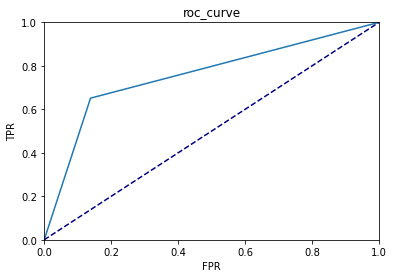

In [418]:
from sklearn.metrics import roc_curve

fpr, tpr, thr = roc_curve(y_test,y_pred)

plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], color = "navy", ls = "--")
plt.title("roc_curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
  
print("roc_auc_score :", roc_auc_score(y_test, y_pred))

## 다항 로지스틱 회귀 실습

종속변수가 3개이상의 범주형 변수로 이루어져 있을 때 쓰는 방식

In [419]:
import pandas as pd
from sklearn.model_selection import train_test_split

iris = pd.read_csv("iris.csv")
iris.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [420]:
feature = iris.drop("variety",axis = 1)
label = iris["variety"]

In [421]:
def train_split(feature, label):
    X_train, X_test, y_train, y_test = train_test_split(feature, label,test_size = 0.3, stratify = label)
    
    return X_train, X_test, y_train, y_test
    


In [422]:
X_train, X_test, y_train, y_test = train_split(feature, label)

In [429]:
# 모델 형성
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()


In [430]:
pred = lr.predict(X_test)
pred

array(['Setosa', 'Virginica', 'Virginica', 'Versicolor', 'Setosa',
       'Virginica', 'Versicolor', 'Setosa', 'Virginica', 'Versicolor',
       'Setosa', 'Versicolor', 'Setosa', 'Setosa', 'Setosa', 'Virginica',
       'Versicolor', 'Setosa', 'Versicolor', 'Setosa', 'Setosa',
       'Virginica', 'Virginica', 'Versicolor', 'Virginica', 'Versicolor',
       'Virginica', 'Versicolor', 'Virginica', 'Virginica', 'Versicolor',
       'Setosa', 'Versicolor', 'Setosa', 'Versicolor', 'Setosa',
       'Virginica', 'Virginica', 'Versicolor', 'Versicolor', 'Virginica',
       'Setosa', 'Virginica', 'Versicolor', 'Setosa'], dtype=object)

In [432]:
cm = confusion_matrix(y_test, pred)
# cm

cmtb = pd.DataFrame(data = cm, columns = ["Setosa","Vircolor","virginica"], index = ["Setosa","Vircolor","virginica"])
cmtb

,Setosa,Vircolor,virginica
Setosa,15,0,0
Vircolor,0,13,2
virginica,0,2,13


In [440]:
from sklearn.metrics import classification_report
accuracy = accuracy_score(y_test, pred)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        15
  Versicolor       0.87      0.87      0.87        15
   Virginica       0.87      0.87      0.87        15

    accuracy                           0.91        45
   macro avg       0.91      0.91      0.91        45
weighted avg       0.91      0.91      0.91        45



In [443]:
roc_auc_score(y_test, lr.predict_proba(X_test), multi_class = "ovr")

0.9925925925925926

In [445]:
lr.predict_proba(X_test)

array([[9.62767983e-01, 3.72317436e-02],
       [2.57380460e-04, 1.68005940e-01],
       [1.70423050e-07, 5.09343916e-03],
       [8.52018843e-02, 9.00087246e-01],
       [9.76662578e-01, 2.33373099e-02],
       [1.31438019e-05, 2.78825199e-02],
       [4.38076712e-02, 9.46306017e-01],
       [9.69949997e-01, 3.00498574e-02],
       [4.55098752e-05, 7.24459076e-02],
       [1.23683581e-02, 9.06345871e-01]])

### 다항 로지스틱 회귀 계수 해석

In [449]:
print("intercept :", lr.intercept_)
print("coef :", lr.coef_)

intercept : [  9.14832466   3.09540489 -12.24372956]
coef : [[-0.40214276  0.8569457  -2.31058138 -0.97209116]
 [ 0.37518576 -0.47752414 -0.20998955 -0.69118335]
 [ 0.026957   -0.37942156  2.52057093  1.66327452]]


In [452]:
pd.DataFrame(data = np.exp(lr.coef_), columns = X_train.columns, index = lr.classes_)

,sepal.length,sepal.width,petal.length,petal.width
Setosa,0.668885,2.355954,0.099204,0.378291
Versicolor,1.455262,0.620317,0.810593,0.500983
Virginica,1.027324,0.684257,12.435695,5.276561


해석 sepal_width 가 1증가 할수록 setosa일 확률이 약 2배 증가함
     sepal_width 이 1증가 할수록 Versicolor이 될 확률은 약 38% 감소함
        